<a href="https://colab.research.google.com/github/JeromeHoen/OC_P3-Developpez_un_moteur_de_recommandations_de_films/blob/master/Notebook_P3_Analyse_exploratoire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Création d'un moteur de recommandation de films : Analyse exploratoire

### Import des fonctions

In [1]:
# data management
import pandas as pd    
import numpy as np
import scipy

# data viz
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from plotly.offline import download_plotlyjs, plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()

# google colab modules

from google.colab import files

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
  
    
# ML algortihms

# text extraction and transformation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# data standardization
from sklearn.preprocessing import StandardScaler, QuantileTransformer

# scoring and cross-validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score

# dimension reduction 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS
from umap import UMAP

# binary value prediction
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

# clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier

# distance calculation
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors

# bayesian optimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
# custom functions

from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram

def full_print(*arg, columns=20, rows=60, colwidth=50):
    """Set pandas.option_context and display a DataFrame"""
    with pd.option_context('display.max_columns', columns,
                           'display.max_rows', rows,
                           'display.max_colwidth', colwidth):
        display(*arg)

def display_circles(pca, axis_ranks=[(0, 1)], labels=None, label_rotation=0, lims=None):
    pcs = pca.components_
    n_comp = pca_popularity.n_components_
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()

In [0]:
url = "https://github.com/JeromeHoen/OC_P3-Developpez_un_moteur_de_recommandations_de_films/raw/master/movie_metadata.csv"
df = pd.read_csv(url)

### Découverte du dataset

In [0]:
full_print(df.sample(5), columns=0)

color       director_name  ...  aspect_ratio  movie_facebook_likes
1956             Color       James Bridges  ...          1.85                   377
2628             Color          Shawn Levy  ...          1.85                   896
43               Color         Lee Unkrich  ...          1.85                 30000
3657   Black and White  John Frankenheimer  ...          1.66                     0
309              Color     Joel Schumacher  ...          1.85                     0

[5 rows x 28 columns]

In [0]:
full_print(df.describe([.01, .1, .25, .5, .75, .9, .99]), columns=0)

num_critic_for_reviews     duration  ...  aspect_ratio  movie_facebook_likes
count             4993.000000  5028.000000  ...   4714.000000           5043.000000
mean               140.194272   107.201074  ...      2.220403           7525.964505
std                121.601675    25.197441  ...      1.385113          19320.445110
min                  1.000000     7.000000  ...      1.180000              0.000000
1%                   2.000000    43.000000  ...      1.330000              0.000000
10%                 17.200000    86.000000  ...      1.850000              0.000000
25%                 50.000000    93.000000  ...      1.850000              0.000000
50%                110.000000   103.000000  ...      2.350000            166.000000
75%                195.000000   118.000000  ...      2.350000           3000.000000
90%                299.800000   134.000000  ...      2.350000          24000.000000
99%                548.080000   189.000000  ...      4.000000          94580.000000
max                813.000000   511.000000  ...     16.000000         349000.000000

[12 rows x 16 columns]

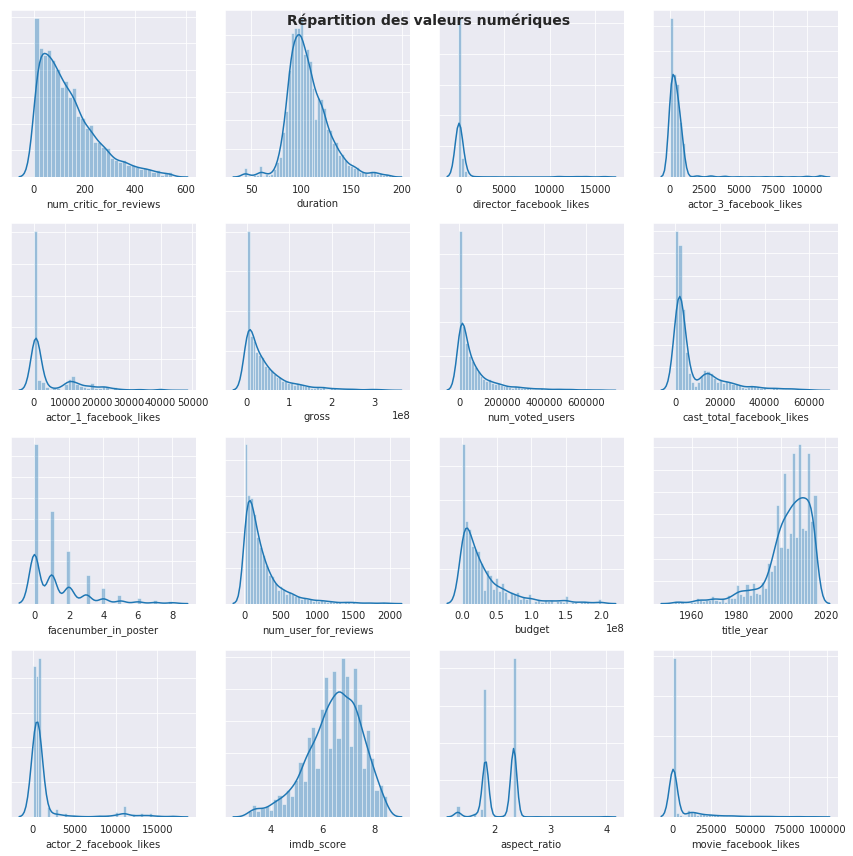

In [85]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

num_cols = df.select_dtypes(include='number').columns
num_range = (.01, .99)

data = []
for col in num_cols:
    values_in_range = df[df[col].between(
        df[col].quantile(num_range[0]),
        df[col].quantile(num_range[1])
    )][col]
    data.append(values_in_range)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12,12))
for i, ax in zip(range(16), axes.flat):
    sns.distplot(data[i], ax=ax)
    ax.set_yticklabels([])

fig.suptitle("Répartition des valeurs numériques", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.show()

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
color                        5024 non-null object
director_name                4939 non-null object
num_critic_for_reviews       4993 non-null float64
duration                     5028 non-null float64
director_facebook_likes      4939 non-null float64
actor_3_facebook_likes       5020 non-null float64
actor_2_name                 5030 non-null object
actor_1_facebook_likes       5036 non-null float64
gross                        4159 non-null float64
genres                       5043 non-null object
actor_1_name                 5036 non-null object
movie_title                  5043 non-null object
num_voted_users              5043 non-null int64
cast_total_facebook_likes    5043 non-null int64
actor_3_name                 5020 non-null object
facenumber_in_poster         5030 non-null float64
plot_keywords                4890 non-null object
movie_imdb_link              5043 non-

In [0]:
def series_to_count(series, split_character=",", ascending=False, return_dtype=None, skipna=True):
    """Return a pandas Series with each element counted after a split element-wise"""
    
    if not hasattr(series, "apply") or not hasattr(series, "name"):
        raise TypeError('Not a pandas Series')
    else:
        if split_character:
            tmp_series = series.apply(lambda s: s.split(split_character) if isinstance(s, str) else s)
        else:
            tmp_series = series.apply(lambda s: list(s) if isinstance(s, str) else s)
        count_dict = {}
        for row in tmp_series:
            if isinstance(row, list):
                for elt in row:
                    if elt in count_dict:
                        count_dict[elt] += 1
                    else:
                        count_dict[elt] = 1
            elif not skipna:
                if row in count_dict:
                    count_dict[row] += 1
                else:
                    count_dict[row] = 1
        return pd.Series(count_dict, index=sorted(count_dict, key=count_dict.get, reverse=not ascending), dtype=return_dtype, name=series.name)

In [0]:
genres = series_to_count(df.genres, "|")
plot_keywords = series_to_count(df.plot_keywords, "|")

In [6]:
genres

Drama          2594
Comedy         1872
Thriller       1411
Action         1153
Romance        1107
Adventure       923
Crime           889
Sci-Fi          616
Fantasy         610
Horror          565
Family          546
Mystery         500
Biography       293
Animation       242
Music           214
War             213
History         207
Sport           182
Musical         132
Documentary     121
Western          97
Film-Noir         6
Short             5
News              3
Reality-TV        2
Game-Show         1
Name: genres, dtype: int64

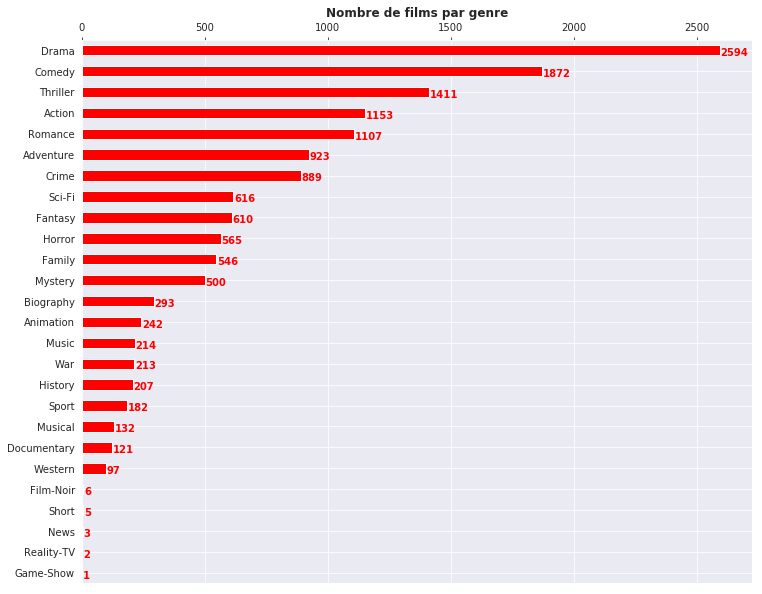

In [36]:
fig, ax = plt.subplots(figsize=(12,10))
genres.plot.barh(ax=ax, color='red')
plt.gca().invert_yaxis()
ax.set_title("Nombre de films par genre", fontweight='bold')
ax.xaxis.tick_top()
for i, v in enumerate(genres):
    ax.text(v + 3, i + .25, str(v), color='red', fontweight='bold')

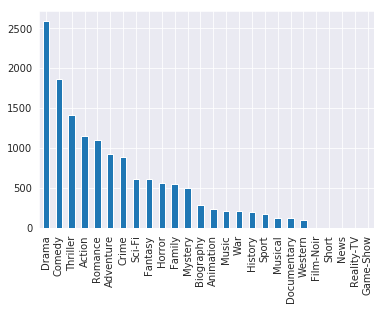

In [122]:
genres.plot.bar()

In [0]:
plot_keywords

love                                          198
friend                                        166
murder                                        161
death                                         132
police                                        126
new york city                                  91
high school                                    89
alien                                          82
school                                         73
boy                                            72
fbi                                            71
revenge                                        70
friendship                                     68
drugs                                          66
prison                                         62
money                                          61
marriage                                       60
island                                         57
dog                                            57
female protagonist                             57


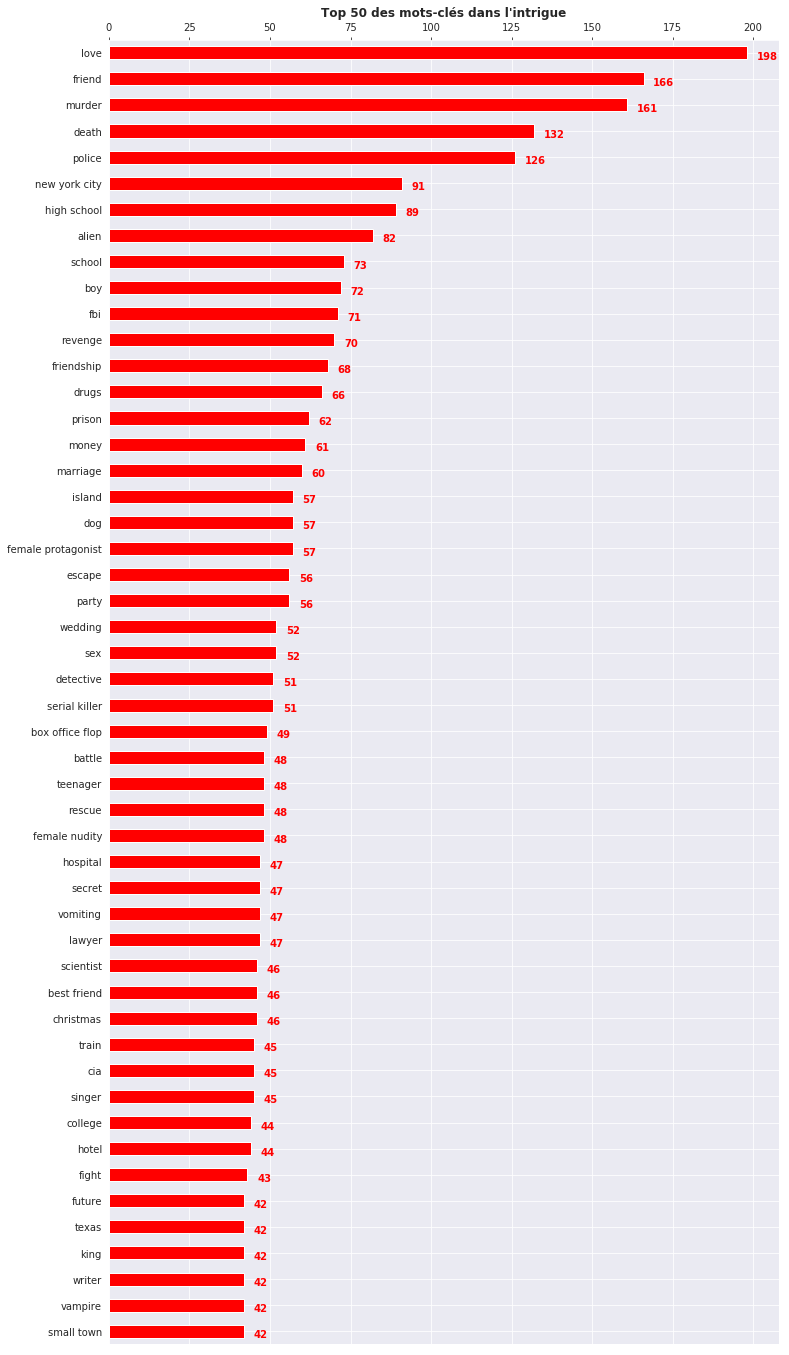

In [38]:
fig, ax = plt.subplots(figsize=(12,24))
plot_keywords[:50].plot.barh(ax=ax, color='red')
plt.gca().invert_yaxis()
ax.set_title("Top 50 des mots-clés dans l'intrigue", fontweight='bold')
ax.xaxis.tick_top()
for i, v in enumerate(plot_keywords[:50]):
    ax.text(v + 3, i + .25, str(v), color='red', fontweight='bold')

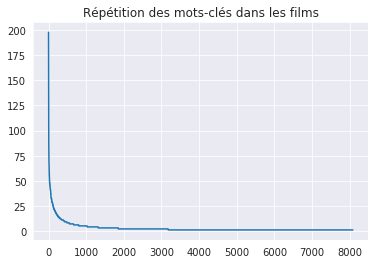

In [8]:
plt.plot(plot_keywords.values)
plt.title("Répétition des mots-clés dans les films")
plt.show()

In [10]:
print(f"Nombre de mots-clés uniques : {(plot_keywords == 1).sum()}")

Nombre de mots-clés uniques : 4908


Beaucoup de mots-clés sont uniques et ne sont partagés que par un seul film.
On réduit les mots-clés à ceux qui sont partagés entre deux films au moins. Cela peut permetre de réduire les dimensions sur la partie analyse

In [0]:
shared_plot_keywords = plot_keywords[plot_keywords > 1]

In [0]:
len(shared_plot_keywords)

3178

In [0]:
keywords_to_lists = df['plot_keywords'].fillna("").str.split("|")
df['shared_plot_keywords'] = keywords_to_lists.apply(lambda lst: "|".join([elt for elt in lst if elt in shared_plot_keywords]))

In [0]:
series_to_count(df.plot_keywords, "|", skipna=False).loc[np.NaN]

153

In [0]:
df.plot_keywords.isna().sum()

153

In [0]:
df.director_name.value_counts()

Steven Spielberg         26
Woody Allen              22
Clint Eastwood           20
Martin Scorsese          20
Ridley Scott             17
Steven Soderbergh        16
Tim Burton               16
Spike Lee                16
Renny Harlin             15
Oliver Stone             14
Robert Zemeckis          13
Sam Raimi                13
Robert Rodriguez         13
Barry Levinson           13
John Carpenter           13
Joel Schumacher          13
Michael Bay              13
Ron Howard               13
Kevin Smith              12
Peter Jackson            12
Richard Donner           12
Brian De Palma           12
Tony Scott               12
Shawn Levy               12
Wes Craven               12
Stephen Frears           11
Rob Reiner               11
Francis Ford Coppola     11
Richard Linklater        11
Chris Columbus           11
                         ..
Sarah Smith               1
Sara Sugarman             1
James David Pasternak     1
Orson Welles              1
René Féret          

#### Vérification qu'il n'y a pas des "duos" de directeurs dans la base

In [0]:
series_to_count(df.director_name.str.lower(), "")

e    6295
a    5847
     5335
r    5205
n    4901
o    3902
i    3768
l    3469
s    3088
t    2764
h    2272
d    2171
c    2148
m    2125
g    1311
k    1291
b    1271
u    1196
y    1156
j     996
p     935
w     820
v     741
f     702
z     310
.     239
-      87
x      70
é      48
q      48
'      21
á      20
ó      16
ö      16
å       8
í       8
ñ       7
ç       5
ô       4
ø       3
ï       2
ä       2
û       1
æ       1
è       1
Name: director_name_count, dtype: int64

In [0]:
df.director_name.apply(lambda s: " and " in str(s)).sum()

0

In [0]:
df.director_name.apply(lambda s: " with " in str(s)).sum()

0

In [0]:
df.director_name[df.director_name.str.contains("\.", na=False)]

48                J.J. Abrams
140        M. Night Shyamalan
141               J.J. Abrams
160               J.J. Abrams
168                Jon M. Chu
179     Alejandro G. Iñárritu
197        M. Night Shyamalan
233           James L. Brooks
380                Jon M. Chu
387            Alan J. Pakula
401        Paul W.S. Anderson
430          George A. Romero
461               D.J. Caruso
506        Paul W.S. Anderson
544              F. Gary Gray
549           James L. Brooks
558        Paul W.S. Anderson
562        M. Night Shyamalan
579        M. Night Shyamalan
581        M. Night Shyamalan
595        M. Night Shyamalan
596        Paul W.S. Anderson
675            David S. Goyer
678        Paul W.S. Anderson
679        Paul W.S. Anderson
724              F. Gary Gray
745        M. Night Shyamalan
761          David O. Russell
793        Paul W.S. Anderson
824        Paul W.S. Anderson
                ...          
4445     Timothy Woodward Jr.
4457      Leslie H. Martinson
4459      

In [0]:
df.director_name[df.director_name.str.contains("-", na=False)]

244          Cedric Nicolas-Troyan
414            Jean-Jacques Annaud
555            Florent-Emilio Siri
578            Jean-Jacques Annaud
611            Jean-Jacques Annaud
627            Michael Caton-Jones
753            Michael Caton-Jones
763             Jean-Pierre Jeunet
810                 Pou-Soi Cheang
889             Jean-Pierre Jeunet
958             Jaume Collet-Serra
1013            Jaume Collet-Serra
1019                  Costa-Gavras
1176            Jean-Pierre Jeunet
1190            Sam Taylor-Johnson
1232            Jaume Collet-Serra
1285           Michael Caton-Jones
1298            Jean-Pierre Jeunet
1313              Jean-Marie Poiré
1323             Peter Ho-Sun Chan
1325                  Joon-ho Bong
1344                  Kar-Wai Wong
1451            Jaume Collet-Serra
1488              Jean-Marc Vallée
1505           Jean-Paul Rappeneau
1555            Jean-Pierre Jeunet
1564                Hyung-rae Shim
1684          Jean-François Richet
1703                

#### Analyse des variables catégorielles

In [0]:
df.color.value_counts()

Color               4815
 Black and White     209
Name: color, dtype: int64

In [0]:
df['color'] = (df['color']=='Color').astype(np.uint8)

In [0]:
df.language.value_counts()

English       4704
French          73
Spanish         40
Hindi           28
Mandarin        26
German          19
Japanese        18
Italian         11
Cantonese       11
Russian         11
Portuguese       8
Korean           8
Hebrew           5
Arabic           5
Swedish          5
Danish           5
Polish           4
Dutch            4
Norwegian        4
Persian          4
Thai             3
Chinese          3
None             2
Icelandic        2
Zulu             2
Dari             2
Romanian         2
Indonesian       2
Aboriginal       2
Slovenian        1
Swahili          1
Aramaic          1
Filipino         1
Hungarian        1
Panjabi          1
Telugu           1
Maya             1
Tamil            1
Bosnian          1
Czech            1
Mongolian        1
Kazakh           1
Vietnamese       1
Kannada          1
Urdu             1
Dzongkha         1
Greek            1
Name: language, dtype: int64

In [0]:
df.country.value_counts()

USA                     3807
UK                       448
France                   154
Canada                   126
Germany                   97
Australia                 55
India                     34
Spain                     33
China                     30
Japan                     23
Italy                     23
Hong Kong                 17
Mexico                    17
New Zealand               15
South Korea               14
Ireland                   12
Russia                    11
Denmark                   11
Brazil                     8
South Africa               8
Norway                     8
Sweden                     6
Netherlands                5
Thailand                   5
Poland                     5
Israel                     4
Iran                       4
Romania                    4
Argentina                  4
Belgium                    4
                        ... 
Taiwan                     2
Greece                     2
Official site              1
Colombia      

####Popularité des acteurs

#####Nombre de likes inconsistent

In [86]:
actors = {}

for i in ("1", "2", "3"):
    name_col = "actor_"+i+"_name"
    likes_col = "actor_"+i+"_facebook_likes"
    
    for idx in df.index:
        actor_name = df.loc[idx, name_col]
        actor_likes = df.loc[idx, likes_col]
        if actor_name in actors:
            if actors[actor_name] != actor_likes:
                raise ValueError(f"Inconsitent number of likes: index {idx}, col {i}")
        elif actor_name:
            actors[actor_name] = actor_likes

ValueError: ignored

In [53]:
df.loc[1187, 'actor_1_name']

'Bruce Greenwood'

In [46]:
df[df["actor_1_name"]=="Bruce Greenwood"][['actor_1_name', 'actor_1_facebook_likes']]

actor_1_name  actor_1_facebook_likes
492   Bruce Greenwood                   981.0
1187  Bruce Greenwood                   984.0
1637  Bruce Greenwood                   984.0
2455  Bruce Greenwood                   989.0
2676  Bruce Greenwood                   989.0
2699  Bruce Greenwood                   989.0
3216  Bruce Greenwood                   990.0
3771  Bruce Greenwood                   990.0
4290  Bruce Greenwood                   991.0
4411  Bruce Greenwood                   991.0
4762  Bruce Greenwood                   991.0

#####Moyenne des likes

In [0]:
actors = {}

for i in ("1", "2", "3"):
    name_col = "actor_"+i+"_name"
    likes_col = "actor_"+i+"_facebook_likes"
    
    for idx in df.index:
        actor_name = df.loc[idx, name_col]
        actor_likes = df.loc[idx, likes_col]
            
        if actor_name in actors:
            if actor_likes:
                actors[actor_name].append(actor_likes)
        elif actor_name is not np.NaN:
            if actor_likes is not np.NaN:
                actors[actor_name] = [actor_likes]
            else:
                actors[actor_name] = []
            
discrepancies = {}
actors_likes = {}
for actor in actors:
    if actors[actor]:
        
        min_likes = min(actors[actor])
        max_likes = max(actors[actor])
        if min_likes < max_likes:
            discrepancies[actor] = max_likes - min_likes
    
        mean_likes = int(round(np.mean(actors[actor])))
    else:
        mean_likes = np.NaN
    actors_likes[actor] = mean_likes

In [104]:
discrepancies

{'AJ Michalka': 1.0,
 'Agnes Bruckner': 1.0,
 'Aisha Tyler': 1.0,
 'Alia Shawkat': 1.0,
 'Alice Greczyn': 1.0,
 'Alicia Witt': 1.0,
 'Alison Doody': 1.0,
 'Amber Rose Revah': 1.0,
 'Amber Valletta': 1.0,
 'Amy Sedaris': 1.0,
 'Ana de la Reguera': 1.0,
 'Anna Friel': 1.0,
 'Anne Heche': 52.0,
 'Anthony LaPaglia': 1.0,
 'Archie Panjabi': 1.0,
 'Ashley Scott': 1.0,
 'Austin Pendleton': 5.0,
 'Ayelet Zurer': 1.0,
 'Bai Ling': 1.0,
 'Bianca Kajlich': 1.0,
 'Bipasha Basu': 1.0,
 'Bridget Fonda': 1.0,
 'Brittany Daniel': 1.0,
 'Bronagh Gallagher': 1.0,
 'Bruce Greenwood': 10.0,
 'Cara Delevingne': 11.0,
 'Catherine Deneuve': 1.0,
 'Catherine McCormack': 1.0,
 'Cheech Marin': 1.0,
 'Christopher Heyerdahl': 1.0,
 'Common': 1.0,
 'Constance Marie': 1.0,
 'Crystal Lowe': 1.0,
 'Dana Ivey': 3.0,
 'David Rasche': 1.0,
 'Deborah Kara Unger': 1.0,
 'Dyan Cannon': 10.0,
 'Eliza Coupe': 1.0,
 'Ellen Barkin': 1.0,
 'Emma Bell': 1.0,
 'Ernie Reyes Jr.': 1.0,
 'Frank Langella': 1.0,
 'Gretchen Mol': 1.0,


Il y a peu de différences entre le minimum et le maximum de likes pour un acteur

In [0]:
actors_likes = pd.Series(actors_likes, name="actors_likes")
actors_likes.sort_values(ascending=False, inplace=True)

In [106]:
actors_likes

Darcy Donavan                    640000
Matthew Ziff                     260000
Krista Allen                     164000
Andrew Fiscella                  137000
Jimmy Bennett                     87000
Michael Joiner                    77000
Robin Williams                    49000
Craig Stark                       46000
Muse Watson                       45000
Tim Holmes                        44000
Johnny Depp                       40000
Bella Thorne                      35000
Sunil Narkar                      34000
Jennifer Lawrence                 34000
Jizelle Jade                      33000
Chris Moss                        33000
Ryan Gosling                      33000
Rachel Ann Mullins                31000
Marisa Saks                       31000
Mem Ferda                         31000
Veronica Ferres                   30000
Leonardo DiCaprio                 29000
Tom Hardy                         27000
Chris Hemsworth                   26000
Jason Statham                     26000


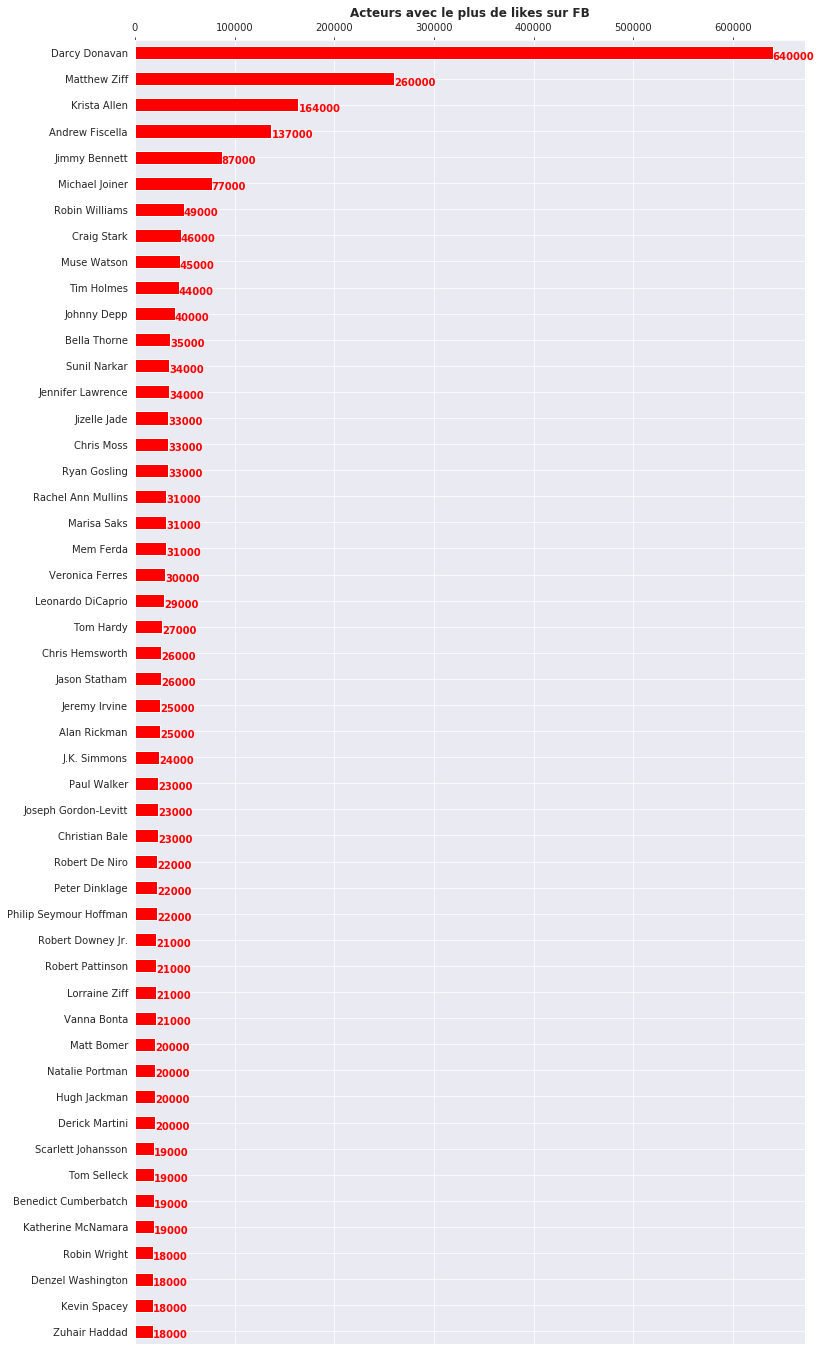

In [108]:
fig, ax = plt.subplots(figsize=(12,24))
actors_likes[:50].plot.barh(ax=ax, color='red')
plt.gca().invert_yaxis()
ax.set_title("Acteurs avec le plus de likes sur FB", fontweight='bold')
ax.xaxis.tick_top()
for i, v in enumerate(actors_likes[:50]):
    ax.text(v + 3, i + .25, str(v), color='red', fontweight='bold')

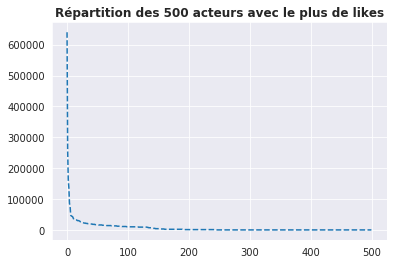

In [127]:
plt.plot(actors_likes[:500].values, '--', )
plt.title('Répartition des 500 acteurs avec le plus de likes', fontweight='bold')
plt.show()

#### Analyse et transformation des content_ratings

In [0]:
df.content_rating.value_counts()

R            2118
PG-13        1461
PG            701
Not Rated     116
G             112
Unrated        62
Approved       55
TV-14          30
TV-MA          20
TV-PG          13
X              13
TV-G           10
Passed          9
NC-17           7
GP              6
M               5
TV-Y7           1
TV-Y            1
Name: content_rating, dtype: int64

In [0]:
full_print(df[df.content_rating=="TV-14"], columns=0)

color  ...                               shared_plot_keywords
177       1  ...          cult tv|detective|drugs|police|undercover
404       1  ...    blood|cannibalism|fbi|manipulation|psychiatrist
537       1  ...  based on comic|based on comic book|dc comics|s...
593       1  ...  apocalypse|death|husband wife relationship|mot...
821       1  ...                       apache|bank robbery|baseball
857       1  ...  2000s|21st century|alternate history|message f...
1404      1  ...                                                   
1620      1  ...  football|football coach|high school|small town...
1736      1  ...                      epidemic|mission|plague|virus
1802      1  ...     brain capacity|fbi|fictional drug|intelligence
2303      1  ...                                                   
2370      1  ...                                                   
2609      1  ...  generation y|millennial generation|murder|teen...
2702      1  ...                psychic|spin off|supernatural power
3012      1  ...                                    alien|radiation
3174      1  ...  anthropologist|fbi|fbi agent|forensics|investi...
3303      1  ...  family relationships|los angeles california|so...
3376      1  ...                     bet|friend|secret|surveillance
3490      1  ...  action heroine|coming of age|destiny|double li...
3509      1  ...  female lead|future|mixed martial arts|post apo...
3604      1  ...     male frontal nudity|male nudity|tv mini series
3623      1  ...  best friend|high school|private detective|sher...
3661      1  ...     black comedy|bully|friend|house|practical joke
3989      1  ...   music business|new york city|record label|singer
4005      1  ...                          cult film|hurricane|shark
4281      1  ...  female protagonist|high school|social satire|t...
4304      1  ...       alternate reality|small town|small town life
4798      1  ...  father daughter relationship|serial killer|sup...
4819      1  ...                        near future|post apocalypse
5039      1  ...       cult|fbi|hideout|prison escape|serial killer

[30 rows x 29 columns]

#### Content_rating vers 3 variables binaires et remplissage des valeurs manquantes

In [0]:
# https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system
# [suitable for children, suitable for teenargers (below 18), was shown in theaters (or on TV)]
ratings = {
    "PG-13": [0, 1, 1],
    "PG": [1, 1, 1],
    "G": [1, 1, 1],
    "R": [0, 0, 1],
    "TV-14": [0, 1, 0],
    "TV-PG": [0, 1, 0],
    "TV-MA": [0, 0, 0],
    "TV-G": [1, 1, 0],
    "TV-Y": [1, 1, 0],
    "NC-17": [0, 0, 1],
    "X": [0, 0, 1],
    "TV-Y7": [1, 1, 0],
    "GP": [1, 1, 1],
    "M": [1, 1, 1],
    np.NaN: [np.NaN, np.NaN, np.NaN]
}

ratings_to_be_filled = [
    "Not Rated",
    "Unrated",
    "Approved",
    "Passed",
]

In [12]:
df_genre_rating = df[['director_name', 'genres', 'content_rating']]
df_genre_rating['content_rating'] = df_genre_rating['content_rating'].replace(ratings_to_be_filled)
print(df_genre_rating['content_rating'].unique())
print(df['content_rating'].unique())

['PG-13' nan 'PG' 'G' 'R' 'TV-14' 'TV-PG' 'TV-MA' 'TV-G' 'TV-Y' 'NC-17'
 'X' 'TV-Y7' 'GP' 'M']
['PG-13' nan 'PG' 'G' 'R' 'TV-14' 'TV-PG' 'TV-MA' 'TV-G' 'Not Rated'
 'Unrated' 'Approved' 'TV-Y' 'NC-17' 'X' 'TV-Y7' 'GP' 'Passed' 'M']


In [13]:
df_genre_rating[[
    'suitable_for_children',
    'suitable_for_young_teenagers',
    'shown_in_theaters'
]] = pd.DataFrame(
    df_genre_rating.content_rating.apply(lambda s: pd.Series({
        'suitable_for_children': ratings[s][0],
        'suitable_for_young_teenagers': ratings[s][1],
        'shown_in_theaters': ratings[s][2]}))
    , index=df.index
)
df_genre_rating.sample(10)

director_name  ... shown_in_theaters
3945  Barry Levinson  ...               1.0
1580  Frank Marshall  ...               1.0
2801   Josh Schwartz  ...               1.0
3924    Oliver Stone  ...               1.0
3317      Scott Mann  ...               1.0
1441   Andrew Niccol  ...               1.0
3620    Zach Cregger  ...               1.0
4463        Ham Tran  ...               1.0
1380    Les Mayfield  ...               1.0
4098    Darren Stein  ...               1.0

[10 rows x 6 columns]

In [0]:
countvect = CountVectorizer()
X = countvect.fit_transform(df_genre_rating.dropna(subset=['genres', 'content_rating']).genres.str.replace(" ", "").str.replace("-", ""))
y = df_genre_rating.dropna(subset=['genres', 'content_rating'])[['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = RandomForestClassifier(100)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print(classification_report(y_test, y_predict))
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test.values[:,0], y_predict[:,0]))
print(confusion_matrix(y_test.values[:,1], y_predict[:,1]))
print(confusion_matrix(y_test.values[:,2], y_predict[:,2]))

              precision    recall  f1-score   support

           0       0.90      0.59      0.71       179
           1       0.69      0.65      0.67       482
           2       0.98      1.00      0.99       922

   micro avg       0.89      0.85      0.87      1583
   macro avg       0.86      0.74      0.79      1583
weighted avg       0.88      0.85      0.86      1583
 samples avg       0.91      0.88      0.86      1583

              precision    recall  f1-score   support

           0       0.90      0.59      0.71       179
           1       0.69      0.65      0.67       482
           2       0.98      1.00      0.99       922

   micro avg       0.89      0.85      0.87      1583
   macro avg       0.86      0.74      0.79      1583
weighted avg       0.88      0.85      0.86      1583
 samples avg       0.91      0.88      0.86      1583

[[750  12]
 [ 74 105]]
[[319 140]
 [170 312]]
[[  0  19]
 [  1 921]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.



In [0]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_genre_rating.dropna(subset=['genres', 'content_rating']).genres.str.replace(" ", "").str.replace("-", ""))
y = df_genre_rating.dropna(subset=['genres', 'content_rating'])[['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = RandomForestClassifier(20)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test.values[:,0], y_predict[:,0]))
print(confusion_matrix(y_test.values[:,1], y_predict[:,1]))
print(confusion_matrix(y_test.values[:,2], y_predict[:,2]))

              precision    recall  f1-score   support

           0       0.85      0.64      0.73       165
           1       0.71      0.66      0.68       466
           2       0.99      1.00      1.00       910

   micro avg       0.90      0.86      0.88      1541
   macro avg       0.85      0.77      0.80      1541
weighted avg       0.89      0.86      0.87      1541
 samples avg       0.92      0.89      0.88      1541

[[732  19]
 [ 59 106]]
[[324 126]
 [159 307]]
[[  0   6]
 [  1 909]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [0]:
enc = OneHotEncoder(handle_unknown='ignore')
X_director = enc.fit_transform(df_genre_rating.dropna(subset=['genres', 'content_rating']).director_name.fillna("").values.reshape(-1, 1))

tfidf = TfidfVectorizer()
X_genre = tfidf.fit_transform(df_genre_rating.dropna(subset=['genres', 'content_rating']).genres.str.replace(" ", "").str.replace("-", ""))

X = scipy.sparse.hstack((X_director, X_genre))
y = df_genre_rating.dropna(subset=['genres', 'content_rating'])[['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf = RandomForestClassifier(100)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test.values[:,0], y_predict[:,0]))
print(confusion_matrix(y_test.values[:,1], y_predict[:,1]))
print(confusion_matrix(y_test.values[:,2], y_predict[:,2]))

              precision    recall  f1-score   support

           0       0.87      0.58      0.69       179
           1       0.72      0.64      0.68       482
           2       1.00      1.00      1.00       922

   micro avg       0.91      0.84      0.87      1583
   macro avg       0.86      0.74      0.79      1583
weighted avg       0.90      0.84      0.87      1583
 samples avg       0.92      0.88      0.87      1583

[[747  15]
 [ 76 103]]
[[340 119]
 [175 307]]
[[ 15   4]
 [  0 922]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


In [15]:
enc = OneHotEncoder(handle_unknown='ignore')
X_director = enc.fit_transform(df_genre_rating.dropna(subset=['genres', 'content_rating']).fillna("").director_name.values.reshape(-1, 1))

tfidf = TfidfVectorizer()
X_genre = tfidf.fit_transform(df_genre_rating.dropna(subset=['genres', 'content_rating']).genres.str.replace(" ", "").str.replace("-", ""))

X = scipy.sparse.hstack((X_director, X_genre))
y = df_genre_rating.dropna(subset=['genres', 'content_rating'])[['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

log_reg = {}
for col in ['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']:
    #cv = cross_val_score(LogisticRegression(), X, y.values[:, col], n_jobs=-1)
    log_reg[col] = LogisticRegressionCV(n_jobs=10, cv=5).fit(X, y[col])
    print(log_reg[col].score(X, y[col]))

0.9096705632306057
0.8786397449521786
0.9968119022316685


In [16]:
fill_index = df_genre_rating[(~df_genre_rating.genres.isna() & df_genre_rating.content_rating.isna())].index

y_fill_predict = {}
X_fill = scipy.sparse.hstack((
    enc.transform(df_genre_rating.loc[fill_index, 'director_name'].fillna("").values.reshape(-1, 1)),
    tfidf.transform(df_genre_rating.loc[fill_index, 'genres'].str.replace(" ", "").str.replace("-", ""))
))

for col in ['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']:
    y_fill_predict[col] = log_reg[col].predict(X_fill)
    print(y_fill_predict[col].shape)

(338,)
(338,)
(338,)


In [0]:
for col in ['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']:
    df_genre_rating.loc[fill_index, col] = y_fill_predict[col]

In [0]:
df[['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']] = df_genre_rating[['suitable_for_children', 'suitable_for_young_teenagers', 'shown_in_theaters']]

In [57]:
display(df_genre_rating.dropna(subset=['genres'])[['genres', 'suitable_for_children', 'suitable_for_young_teenagers']])

genres  ...  suitable_for_young_teenagers
0                       Action|Adventure|Fantasy|Sci-Fi  ...                           1.0
1                              Action|Adventure|Fantasy  ...                           1.0
2                             Action|Adventure|Thriller  ...                           1.0
3                                       Action|Thriller  ...                           1.0
4                                           Documentary  ...                           1.0
5                               Action|Adventure|Sci-Fi  ...                           1.0
6                              Action|Adventure|Romance  ...                           1.0
7     Adventure|Animation|Comedy|Family|Fantasy|Musi...  ...                           1.0
8                               Action|Adventure|Sci-Fi  ...                           1.0
9                      Adventure|Family|Fantasy|Mystery  ...                           1.0
10                              Action|Adventure|Sci-Fi  ...                           1.0
11                              Action|Adventure|Sci-Fi  ...                           1.0
12                                     Action|Adventure  ...                           1.0
13                             Action|Adventure|Fantasy  ...                           1.0
14                             Action|Adventure|Western  ...                           1.0
15                      Action|Adventure|Fantasy|Sci-Fi  ...                           1.0
16                      Action|Adventure|Family|Fantasy  ...                           1.0
17                              Action|Adventure|Sci-Fi  ...                           1.0
18                             Action|Adventure|Fantasy  ...                           1.0
19        Action|Adventure|Comedy|Family|Fantasy|Sci-Fi  ...                           1.0
20                                    Adventure|Fantasy  ...                           1.0
21                             Action|Adventure|Fantasy  ...                           1.0
22                       Action|Adventure|Drama|History  ...                           1.0
23                                    Adventure|Fantasy  ...                           1.0
24                             Adventure|Family|Fantasy  ...                           1.0
25                       Action|Adventure|Drama|Romance  ...                           1.0
26                                        Drama|Romance  ...                           1.0
27                              Action|Adventure|Sci-Fi  ...                           1.0
28                     Action|Adventure|Sci-Fi|Thriller  ...                           1.0
29                     Action|Adventure|Sci-Fi|Thriller  ...                           1.0
...                                                 ...  ...                           ...
5013                                       Drama|Family  ...                           1.0
5014                              Action|Crime|Thriller  ...                           0.0
5015                                       Comedy|Drama  ...                           0.0
5016                               Crime|Drama|Thriller  ...                           0.0
5017                                     Comedy|Romance  ...                           1.0
5018                                              Drama  ...                           1.0
5019                            Horror|Mystery|Thriller  ...                           0.0
5020                              Drama|Horror|Thriller  ...                           0.0
5021                               Comedy|Drama|Romance  ...                           0.0
5022                                              Drama  ...                           0.0
5023                                            Romance  ...                           1.0
5024                                    Sci-Fi|Thriller  ...                           1.0
5025                                Comedy|Cr

#### Analyse des budgets et recettes

In [0]:
average_roi = (df.dropna(subset=['budget', 'gross']).gross.sum() - df.dropna(subset=['budget', 'gross']).budget.sum()) / df.dropna(subset=['budget', 'gross']).budget.sum()
average_roi

0.12927850009698813

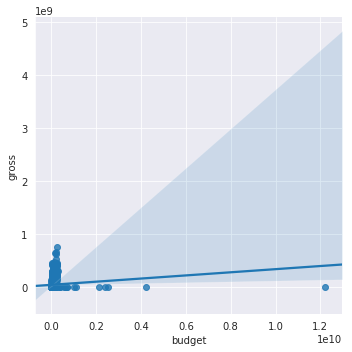

In [0]:
sns.lmplot('budget', 'gross', df.dropna(subset=['budget', 'gross']))

In [0]:
full_print(df.loc[df.budget.idxmax()])

color                                                                           1
director_name                                                        Joon-ho Bong
num_critic_for_reviews                                                        363
duration                                                                      110
director_facebook_likes                                                       584
actor_3_facebook_likes                                                         74
actor_2_name                                                         Kang-ho Song
actor_1_facebook_likes                                                        629
gross                                                                 2.20141e+06
genres                                                 Comedy|Drama|Horror|Sci-Fi
actor_1_name                                                            Doona Bae
movie_title                                                             The Host 
num_voted_users 

Le budget est en won (sud-corréens) et les recettes en dollar. Problème : 1 won = 0,00084$

In [0]:
average_roi = (df[df['country']=='USA'].dropna(subset=['budget', 'gross']).gross.sum() - df[df['country']=='USA'].dropna(subset=['budget', 'gross']).budget.sum()) / df[df['country']=='USA'].dropna(subset=['budget', 'gross']).budget.sum()
average_roi

0.4311193031231128

In [0]:
full_print(df[(df['country']=='France') & (df['title_year']<2002)], columns=0)

color  ... shown_in_theaters
332       1  ...               1.0
677       1  ...               1.0
687       1  ...               1.0
702       1  ...               1.0
999       0  ...               1.0
1016      1  ...               1.0
1217      0  ...               1.0
1289      1  ...               1.0
1298      0  ...               1.0
1313      1  ...               1.0
1505      1  ...               1.0
1782      1  ...               1.0
1855      1  ...               1.0
1916      1  ...               1.0
2339      1  ...               1.0
2383      1  ...               1.0
2598      1  ...               1.0
2720      1  ...               1.0
2723      1  ...               1.0
2808      1  ...               1.0
2869      1  ...               1.0
2879      1  ...               1.0
3179      1  ...               1.0
3209      1  ...               1.0
3220      1  ...               1.0
3222      1  ...               1.0
3335      1  ...               1.0
3449      1  ...               1.0
3522      1  ...               1.0
3657      0  ...               1.0
4276      1  ...               1.0
4295      1  ...               1.0
4398      1  ...               1.0
4419      1  ...               1.0
4667      1  ...               1.0
4829      1  ...               1.0
4835      1  ...               1.0
4952      0  ...               1.0

[38 rows x 32 columns]

#### Web scrapping pour corriger les devises des budgets

In [0]:
import bs4
from urllib.request import urlopen

base_url = "https://pro.imdb.com/title/"
html = urlopen(base_url + "tt0120882").read()
soup = bs4.BeautifulSoup(html)

In [129]:
print(soup.prettify()[:10000])

<!DOCTYPE html>
<!--[if IE 8]><html class="a-no-js a-lt-ie10 a-lt-ie9 a-ie8" data-19ax5a9jf="dingo"><![endif]-->
<!--[if IE 9]><html class="a-no-js a-lt-ie10 a-ie9" data-19ax5a9jf="dingo"><![endif]-->
<!--[if !IE]><!-->
<html class="a-no-js" data-19ax5a9jf="dingo">
 <!--<![endif]-->
 <head>
  <script>
   var aPageStart = (new Date()).getTime();
  </script>
  <meta charset="utf-8"/>
  <script data-a-state='{"key": "csm"}' type="a-state">
   {"pageType": "title", "subpageType": "v2_cast_public"}
  </script>
  <meta content="See The Visitors II: The Corridors of Time's production, company, and contact information. Explore The Visitors II: The Corridors of Time's box office performance, follow development, and track popularity with MOVIEmeter. IMDbPro — The essential resource for entertainment professionals." name="description"/>
  <meta content="https://m.media-amazon.com/images/M/MV5BNTI5YWYxOTYtMmYyOC00OTg5LTljZTgtMTE0MGZlMGIyZTM3XkEyXkFqcGdeQXVyNzA5NjUyNjM@._V1_.jpg" property="og:image

In [0]:
budget_class = soup.find_all("div", class_="a-section a-spacing-small budget_summary")
budget = budget_class[0].text.split("\n")[1]
print(budget)
print(type(budget))

 FRF140,000,000
<class 'str'>


In [0]:
import re

budget = {}

for i in df.index[:10]:
    
    url = df.at[i, 'movie_imdb_link']
    movie_title = df.at[i, 'movie_title']
    tt = re.search('title/(.*)/', url).group(1)
    
    html = urlopen(base_url + tt).read()
    soup = bs4.BeautifulSoup(html)
    budget_class = soup.find_all("div", class_="budget_summary")

    try:
        movie_budget = budget_class[0].text.split("\n")[1]
        budget[i] = movie_budget.strip()
    except IndexError:
        budget[i] = [movie_title, url]

print(budget)

{0: '$237,000,000', 1: '$300,000,000', 2: '$245,000,000', 3: '$250,000,000', 4: ['Star Wars: Episode VII - The Force Awakens', 'http://www.imdb.com/title/tt5289954/?ref_=fn_tt_tt_1'], 5: '$250,000,000', 6: '$258,000,000', 7: '$260,000,000', 8: '$250,000,000', 9: '$250,000,000'}


In [0]:
!pip install easymoney

     |████████████████████████████████| 10.5MB 12.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/0a/85/7f/9241e28ec82fc671032f9367b429dab07983f4b63375d40792
  Stored in directory: /root/.cache/pip/wheels/57/61/6a/3978e90cf2f9443b94ce56b4fa839850da9076e697be3a27e3
Successfully built easymoney wbdata


In [0]:
from easymoney.money import EasyPeasy

ep = EasyPeasy()
ep.normalize(amount=100, region="France", from_year=1998, to_year=2016, base_currency="USD")

143.4

In [0]:
for i in df.index[:15]:
    
    url = df.at[i, 'movie_imdb_link']
    movie_title = df.at[i, 'movie_title']
    tt = re.search('title/(.*)/', url).group(1)
    
    html = urlopen(base_url + tt).read()
    soup = bs4.BeautifulSoup(html)
    budget_class = soup.find_all("div", class_="budget_summary")

    try:
        movie_budget = budget_class[0].text.split("\n")[1]
        budget[i] = movie_budget.strip()
    except IndexError:
        budget[i] = [movie_title, url]

print(budget)

{0: '$237,000,000', 1: '$300,000,000', 2: '$245,000,000', 3: '$250,000,000', 4: ['Star Wars: Episode VII - The Force Awakens', 'http://www.imdb.com/title/tt5289954/?ref_=fn_tt_tt_1'], 5: '$250,000,000', 6: '$258,000,000', 7: '$260,000,000', 8: '$250,000,000', 9: '$250,000,000', 10: '$250,000,000', 11: '$270,000,000', 12: '$200,000,000', 13: '$225,000,000', 14: '$215,000,000'}


Les budgets et notamment la devise sont scrappés depuis un autre notebook.

#### Correction des budgets depuis le CSV préparé

In [19]:
budget_df = pd.read_csv("https://github.com/JeromeHoen/OC_P3-Developpez_un_moteur_de_recommandations_de_films/raw/master/budgets_corrected.csv", index_col=0)
budget_df.head()

budget_str currency currency_iso       budget   budget_USD
0  $237,000,000        $          USD  237000000.0  237000000.0
1  $300,000,000        $          USD  300000000.0  300000000.0
2  $245,000,000        $          USD  245000000.0  245000000.0
3  $250,000,000        $          USD  250000000.0  250000000.0
5  $250,000,000        $          USD  250000000.0  250000000.0

In [0]:
df['budget_USD'] = budget_df['budget_USD']

nan_idx = df[df['budget_USD'].isna()].index
df.loc[nan_idx, 'budget_USD'] = df.loc[nan_idx, 'budget']

In [21]:
# https://fred.stlouisfed.org/series/CPIAUCNS
CPI = pd.read_csv("https://github.com/JeromeHoen/OC_P3-Developpez_un_moteur_de_recommandations_de_films/raw/master/CPIAUCNS.csv")
CPI.head()

date  price_index
0  1916-01-01      4.53459
1  1917-01-01      5.34359
2  1918-01-01      6.26717
3  1919-01-01      7.22201
4  1920-01-01      8.35045

In [22]:
CPI['year'] = CPI.date.apply(lambda s: float(s[:4]))
CPI.head()

date  price_index    year
0  1916-01-01      4.53459  1916.0
1  1917-01-01      5.34359  1917.0
2  1918-01-01      6.26717  1918.0
3  1919-01-01      7.22201  1919.0
4  1920-01-01      8.35045  1920.0

In [23]:
CPI['mult_factor'] = 100 / CPI.price_index
CPI.tail()

date  price_index    year  mult_factor
96   2012-01-01     95.66128  2012.0     1.045355
97   2013-01-01     97.06255  2013.0     1.030263
98   2014-01-01     98.63712  2014.0     1.013817
99   2015-01-01     98.75413  2015.0     1.012616
100  2016-01-01    100.00000  2016.0     1.000000

In [24]:
year_factor = CPI[['year', 'mult_factor']].set_index('year').to_dict()['mult_factor']
year_factor

{1916.0: 22.05271038837028,
 1917.0: 18.714010618329624,
 1918.0: 15.95616522289965,
 1919.0: 13.846560722015061,
 1920.0: 11.97540252321731,
 1921.0: 13.445775875051094,
 1922.0: 14.328782512007518,
 1923.0: 14.076675652277958,
 1924.0: 14.015024105841462,
 1925.0: 13.682117882391251,
 1926.0: 13.559726527435394,
 1927.0: 13.826630643684965,
 1928.0: 13.987794250736808,
 1929.0: 13.987794250736808,
 1930.0: 14.371677447820032,
 1931.0: 15.781284028393687,
 1932.0: 17.593677536040648,
 1933.0: 18.557248182781468,
 1934.0: 17.93329531474727,
 1935.0: 17.486858625742755,
 1936.0: 17.30819491104453,
 1937.0: 16.68646794195779,
 1938.0: 17.03185809055839,
 1939.0: 17.256344726547336,
 1940.0: 17.133174451695584,
 1941.0: 16.29930744242677,
 1942.0: 14.694321379502892,
 1943.0: 13.866567566930456,
 1944.0: 13.643234865559565,
 1945.0: 13.339914357749823,
 1946.0: 12.297551557484905,
 1947.0: 10.750595851775083,
 1948.0: 9.982969054792523,
 1949.0: 10.080807754963791,
 1950.0: 9.972595308093

In [0]:
df['budget_inflation_adjusted'] = df['title_year'].map(year_factor, na_action='ignore').fillna(1) * df['budget_USD']
df['gross_inflation_adjusted'] = df['title_year'].map(year_factor, na_action='ignore').fillna(1) * df['gross']

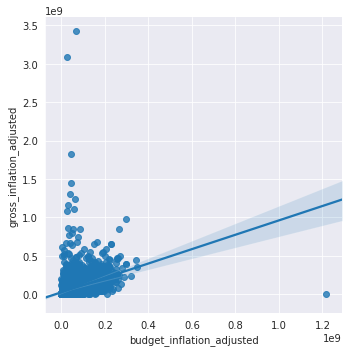

In [142]:
sns.lmplot(x='budget_inflation_adjusted', y='gross_inflation_adjusted', data=df)

In [143]:
((df.gross_inflation_adjusted - df.budget_inflation_adjusted) / df.budget_inflation_adjusted).mean()

4.981767120419759

In [0]:
df.loc[df.budget_inflation_adjusted.idxmax()]

color                                                                       Color
director_name                                                        Carlos Saura
num_critic_for_reviews                                                         35
duration                                                                      115
director_facebook_likes                                                        98
actor_3_facebook_likes                                                          4
actor_2_name                                                   Juan Luis Galiardo
actor_1_facebook_likes                                                        341
gross                                                                 1.68731e+06
genres                                                              Drama|Musical
actor_1_name                                                          Mía Maestro
movie_title                                                                Tango 
num_voted_users 

In [0]:
CPI[CPI['date']==1998]

date  price_index  mult_factor
82  1998.0     67.91811     1.472361

In [0]:
df.at[3851, 'budget_USD'] = float(df.at[3851, 'budget'] / 194.33)
df.at[3851, 'budget_inflation_adjusted'] = float(df.at[3851, 'budget_USD'] * 1.472361)

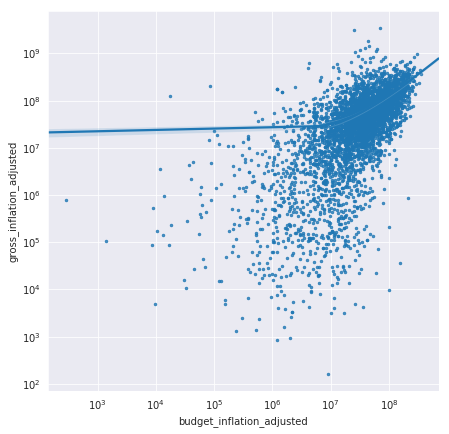

In [145]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot(x='budget_inflation_adjusted', y='gross_inflation_adjusted', data=df, ax=ax, scatter_kws={"s": 6})

In [0]:
df.loc[df.gross_inflation_adjusted.idxmin()]

color                                                                       Color
director_name                                                 Ekachai Uekrongtham
num_critic_for_reviews                                                         66
duration                                                                       96
director_facebook_likes                                                         3
actor_3_facebook_likes                                                        305
actor_2_name                                                           Mike Dopud
actor_1_facebook_likes                                                       2000
gross                                                                         162
genres                                                      Action|Crime|Thriller
actor_1_name                                                    Michael Jai White
movie_title                                                           Skin Trade 
num_voted_users 

In [0]:
df.loc[3330, ['gross', 'gross_inflation_adjusted']] = 595268.0

In [0]:
df['return_on_investment'] = (df['gross_inflation_adjusted'] - df['budget_inflation_adjusted']) / df['budget_inflation_adjusted']
df['margin'] = df['gross_inflation_adjusted'] - df['budget_inflation_adjusted']

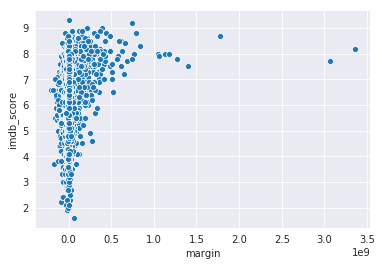

In [150]:
sns.scatterplot(x='margin', y='imdb_score', data=df)

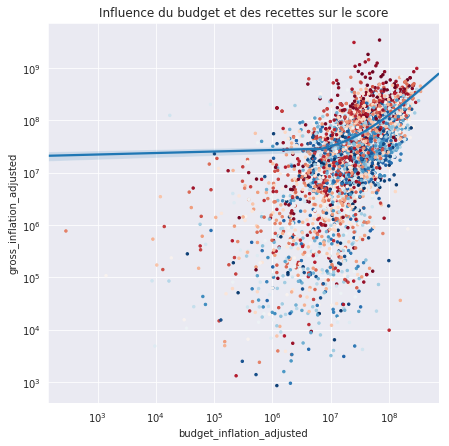

In [171]:
from sklearn.preprocessing import PowerTransformer
data=df.dropna(
    subset=['budget_inflation_adjusted', 'gross_inflation_adjusted', 'imdb_score']
)

scaled_score = QuantileTransformer().fit_transform(data['imdb_score'].values.reshape(-1, 1))
color= plt.cm.RdBu_r(scaled_score.ravel(), alpha=1)

fig, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.regplot(x='budget_inflation_adjusted', y='gross_inflation_adjusted', data=data, 
            scatter_kws={"s": 6, "color": color}, ax=ax)

plt.title("Influence du budget et des recettes sur le score")
plt.show()

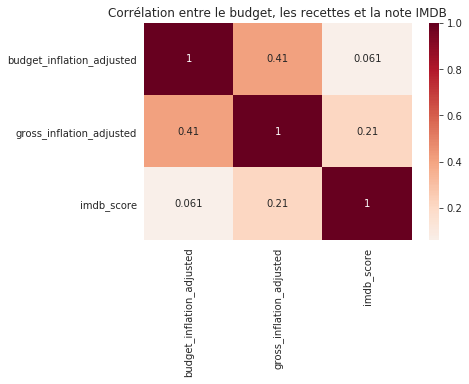

In [32]:
sns.heatmap(df[['budget_inflation_adjusted', 'gross_inflation_adjusted', 'imdb_score']].corr(), center=0, annot=True, cmap='RdBu_r')
plt.title("Corrélation entre le budget, les recettes et la note IMDB")
plt.show()

Comme attendu, les recettes sont positivement corrélées au score. Les films avaient une bonne critique sont plus vus. En revanche, on ne trouve pas de corrélation nette entre la note et le budget, les films les plus chers ne sont pas forcément les meilleurs

#### Réorganisation des colonnes pour plus de lisibilité

In [0]:
new_column_order = [
    'movie_title', 'genres', 'title_year', 'director_name', 
    'actor_1_name', 'actor_2_name', 'actor_3_name',
    'budget', 'budget_USD', 'budget_inflation_adjusted',
    'gross', 'gross_inflation_adjusted',
    'return_on_investment', 'margin',
    'movie_facebook_likes', 'director_facebook_likes', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes', 'cast_total_facebook_likes',
    'facenumber_in_poster', 
    'movie_imdb_link', 'language', 'country',
    'imdb_score', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews',
    'duration', 'color', 'aspect_ratio',
    'plot_keywords', 'shared_plot_keywords',
    'content_rating', 'suitable_for_children', 'suitable_for_young_teenagers',
    'shown_in_theaters'
]

# check if no column is missing or in extra
for col in new_column_order:
    if col not in df.columns:
        print(col)
        
for col in df.columns:
    if col not in new_column_order:
        print(col)

In [37]:
df = df[new_column_order]
df.head()

movie_title  ... shown_in_theaters
0                                            Avatar   ...               1.0
1          Pirates of the Caribbean: At World's End   ...               1.0
2                                           Spectre   ...               1.0
3                             The Dark Knight Rises   ...               1.0
4  Star Wars: Episode VII - The Force Awakens    ...  ...               1.0

[5 rows x 37 columns]

#### Découverte des variables textuelles

In [38]:
genres

Drama          2594
Comedy         1872
Thriller       1411
Action         1153
Romance        1107
Adventure       923
Crime           889
Sci-Fi          616
Fantasy         610
Horror          565
Family          546
Mystery         500
Biography       293
Animation       242
Music           214
War             213
History         207
Sport           182
Musical         132
Documentary     121
Western          97
Film-Noir         6
Short             5
News              3
Reality-TV        2
Game-Show         1
Name: genres, dtype: int64

In [41]:
genre_dummies = pd.DataFrame(index=df.index)
for genre in genres[:21].index:
    genre_dummies[genre] = df.genres.fillna("").str.contains(genre).astype(np.uint8)

pd.concat((df['genres'], genre_dummies), axis=1).head()

genres  Drama  ...  Documentary  Western
0  Action|Adventure|Fantasy|Sci-Fi      0  ...            0        0
1         Action|Adventure|Fantasy      0  ...            0        0
2        Action|Adventure|Thriller      0  ...            0        0
3                  Action|Thriller      0  ...            0        0
4                      Documentary      0  ...            1        0

[5 rows x 22 columns]

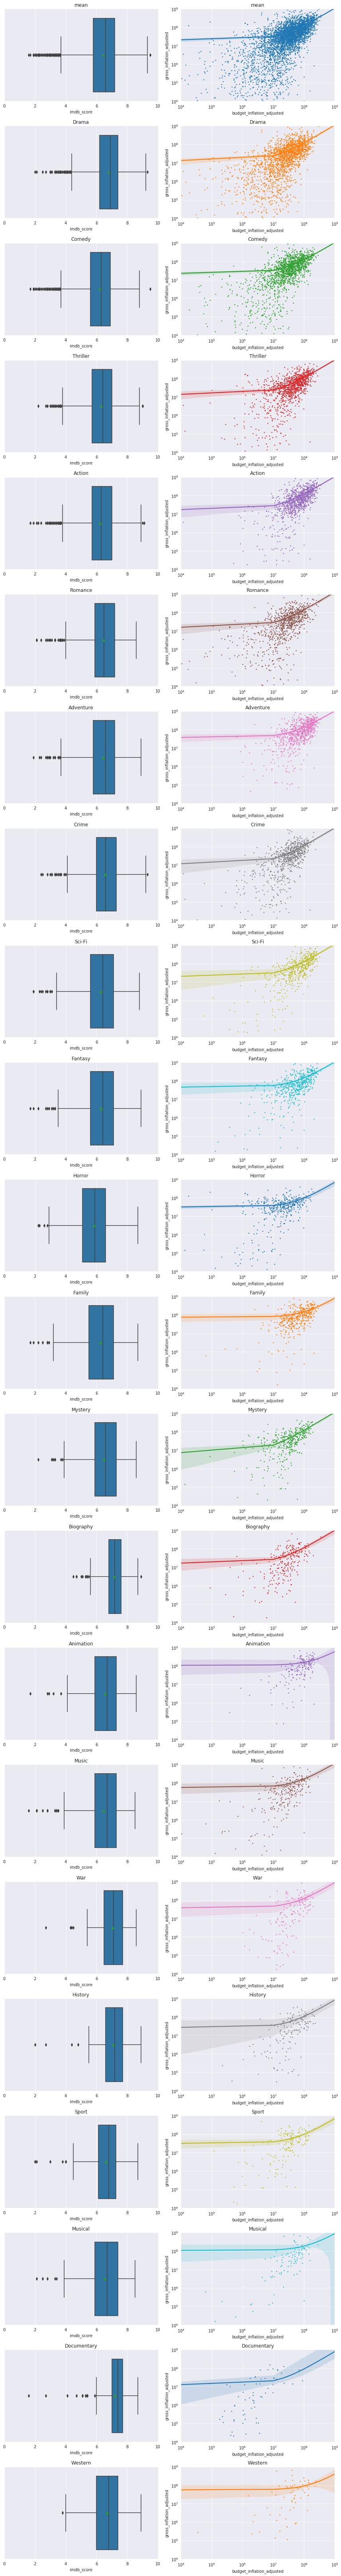

In [54]:
tmp = pd.concat((df, genre_dummies), axis=1)
hue_vars = genre_dummies.columns[:21]
y_vars = ['imdb_score', 'budget_inflation_adjusted', 'gross_inflation_adjusted']

fig, axes = plt.subplots(nrows= 1 + len(hue_vars), ncols=2, figsize=(12,90))

for i in range(axes.shape[0]):
    axes[i, 0].set_xlim(left=0, right=10)
    
    axes[i, 1].set(xscale="log", yscale="log")
    axes[i, 1].set_xlim(left=1e4, right=1e9)
    axes[i, 1].set_ylim(bottom=1e4, top=1e9)

for i, hue in enumerate(['mean'] + list(hue_vars)):
    
    if hue=='mean':
        tmp_j = tmp
    else:
        tmp_j = tmp[tmp[hue]==1]
        
    ax = sns.boxplot(y='imdb_score', data=tmp_j, showmeans=True,
                     orient='h', ax=axes[i, 0], 
                     )
    
    
    ax = sns.regplot(x='budget_inflation_adjusted', y='gross_inflation_adjusted', 
                     data=tmp_j, ax=axes[i, 1], scatter_kws={'s': 3})

        
for i in range(axes.shape[0]):
    title = (['mean'] + list(hue_vars))[i]
    for j in range(axes.shape[1]):
        axes[i,j].title.set_text(title)
        
plt.tight_layout()
plt.show()

Les documentaires semblent plus appréciés que les films d'horreur. Les budgets/recettes varient également

In [58]:
full_print(df.sort_values('imdb_score', ascending=False)[:10], columns=0)

movie_title  ... shown_in_theaters
2765                   Towering Inferno               ...               1.0
1937                       The Shawshank Redemption   ...               1.0
3466                                  The Godfather   ...               1.0
4409                           Kickboxer: Vengeance   ...               1.0
2824                            Dekalog               ...               0.0
3207                            Dekalog               ...               0.0
66                                  The Dark Knight   ...               1.0
2837                         The Godfather: Part II   ...               1.0
3481                              Fargo               ...               0.0
339   The Lord of the Rings: The Return of the King   ...               1.0

[10 rows x 37 columns]

#### Des valeurs dupliquées à supprimer

In [0]:
df.duplicated(subset='movie_title', keep=False).sum()

245

In [64]:
df[df.duplicated(subset=['movie_title', 'director_name'], keep=False)].sort_values('movie_title')

movie_title  ... shown_in_theaters
3711               20,000 Leagues Under the Sea   ...               1.0
4894               20,000 Leagues Under the Sea   ...               1.0
4950                          A Dog's Breakfast   ...               1.0
4949                          A Dog's Breakfast   ...               1.0
1420                  A Nightmare on Elm Street   ...               1.0
4352                  A Nightmare on Elm Street   ...               1.0
3007           A Woman, a Gun and a Noodle Shop   ...               1.0
4408           A Woman, a Gun and a Noodle Shop   ...               1.0
1113                        Across the Universe   ...               1.0
4842                        Across the Universe   ...               1.0
33                          Alice in Wonderland   ...               1.0
4128                        Alice in Wonderland   ...               1.0
2639                                      Aloha   ...               1.0
1389                                      Aloha   ...               1.0
3587                Around the World in 80 Days   ...               1.0
271                 Around the World in 80 Days   ...               1.0
2562                                   Bad Moms   ...               1.0
2181                                   Bad Moms   ...               1.0
3967                                    Ben-Hur   ...               1.0
367                                     Ben-Hur   ...               1.0
2613                                    Ben-Hur   ...               1.0
2628                               Big Fat Liar   ...               1.0
2798                               Big Fat Liar   ...               1.0
2882                                   Brothers   ...               1.0
1852                                   Brothers   ...               1.0
4350                                     Carrie   ...               1.0
1662                                     Carrie   ...               1.0
2944                              Casino Royale   ...               1.0
286                               Casino Royale   ...               1.0
4942                                 Cat People   ...               1.0
...                                          ...  ...               ...
4150                                   The Omen   ...               1.0
2771                             The Possession   ...               1.0
1984                             The Possession   ...               1.0
3578              The Return of the Living Dead   ...               1.0
3896              The Return of the Living Dead   ...               1.0
3278               The Texas Chain Saw Massacre   ...               1.0
4936               The Texas Chain Saw Massacre   ...               1.0
305                                 The Tourist   ...               1.0
3170                                The Tourist   ...               1.0
174   The Twilight Saga: Breaking Dawn - Part 2   ...               1.0
187   The Twilight Saga: Breaking Dawn - Part 2   ...               1.0
4681                                 The Unborn   ...               1.0
2546                                 The Unborn   ...               1.0
871                                   The Watch   ...               1.0
4009                                  The Watch   ...               1.0
214                                Total Recall   ...               1.0
656                                Total Recall   ...               1.0
2584                                     Trance   ...               1.0
4631                                     Trance   ...               1.0
2262                                   Twilight   ...               1.0
1378                                   Twilight   ...               1.0
663                                    Unbroken   ...               1.0
1220                                   Unbroken   ...               1.0
1232                                    Unknown   ...               1.0
3981 

In [0]:
df.duplicated(subset=['movie_imdb_link'], keep=False).sum()

241

In [0]:
df.duplicated(keep=False).sum()

90

In [65]:
full_print(df[
                (df.duplicated(subset=['movie_title', 'director_name'], keep=False))
             & ~(df.duplicated(keep=False))
           ].sort_values('movie_title'),
columns=0)


movie_title  ... shown_in_theaters
4894   20,000 Leagues Under the Sea   ...               1.0
3711   20,000 Leagues Under the Sea   ...               1.0
1420      A Nightmare on Elm Street   ...               1.0
4352      A Nightmare on Elm Street   ...               1.0
1113            Across the Universe   ...               1.0
4842            Across the Universe   ...               1.0
4128            Alice in Wonderland   ...               1.0
33              Alice in Wonderland   ...               1.0
2639                          Aloha   ...               1.0
1389                          Aloha   ...               1.0
271     Around the World in 80 Days   ...               1.0
3587    Around the World in 80 Days   ...               1.0
367                         Ben-Hur   ...               1.0
2613                        Ben-Hur   ...               1.0
3967                        Ben-Hur   ...               1.0
2882                       Brothers   ...               1.0
1852                       Brothers   ...               1.0
1662                         Carrie   ...               1.0
4350                         Carrie   ...               1.0
286                   Casino Royale   ...               1.0
2944                  Casino Royale   ...               1.0
1705                Chasing Liberty   ...               1.0
2063                Chasing Liberty   ...               1.0
336                      Cinderella   ...               1.0
4141                     Cinderella   ...               1.0
2650            Clash of the Titans   ...               1.0
213             Clash of the Titans   ...               1.0
2193            Conan the Barbarian   ...               1.0
390             Conan the Barbarian   ...               1.0
430                       Creepshow   ...               1.0
...                              ...  ...               ...
280                      The Island   ...               1.0
79                  The Jungle Book   ...               1.0
1805                The Jungle Book   ...               1.0
3351                 The Karate Kid   ...               1.0
1184                 The Karate Kid   ...               1.0
2647     The Last House on the Left   ...               1.0
4971     The Last House on the Left   ...               1.0
2710                The Love Letter   ...               1.0
4882                The Love Letter   ...               1.0
4584               The Lovely Bones   ...               1.0
337                The Lovely Bones   ...               1.0
84                       The Lovers   ...               1.0
1508                     The Lovers   ...               1.0
1894                       The Omen   ...               1.0
4150                       The Omen   ...               1.0
3578  The Return of the Living Dead   ...               1.0
3896  The Return of the Living Dead   ...               1.0
4936   The Texas Chain Saw Massacre   ...               1.0
3278   The Texas Chain Saw Massacre   ...               1.0
3170                    The Tourist   ...               1.0
305                     The Tourist   ...               1.0
4681                     The Unborn   ...               1.0
2546                     The Unborn   ...               1.0
871                       The Watch   ...               1.0
4009                      The Watch   ...               1.0
1378                       Twilight   ...               1.0
2262                       Twilight   ...               1.0
1232                        Unknown   ...               1.0
3981                        Unknown   ...               1.0
2099            Victor Frankenstein   ...               1.0

[153 rows x 37 columns]

Différences sur "num_voted_users"

In [67]:
full_print(df[
    (df.duplicated(subset=['movie_title', 'director_name', 'num_voted_users'], keep=False))
     & ~(df.duplicated(keep=False))
].sort_values('movie_title'), columns=0)


movie_title  ... shown_in_theaters
1705  Chasing Liberty   ...               1.0
2063  Chasing Liberty   ...               1.0
2710  The Love Letter   ...               1.0
4882  The Love Letter   ...               1.0
84         The Lovers   ...               1.0
1508       The Lovers   ...               1.0

[6 rows x 37 columns]

Différences sur les likes Facebook

In [0]:
num_cols = df.select_dtypes(include='number').columns

In [60]:
num_cols

Index(['title_year', 'budget', 'budget_USD', 'budget_inflation_adjusted',
       'gross', 'gross_inflation_adjusted', 'return_on_investment', 'margin',
       'movie_facebook_likes', 'director_facebook_likes',
       'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'imdb_score', 'num_voted_users',
       'num_critic_for_reviews', 'num_user_for_reviews', 'duration',
       'aspect_ratio', 'suitable_for_children', 'suitable_for_young_teenagers',
       'shown_in_theaters'],
      dtype='object')

In [0]:
def remove_duplicates(df):
    num_cols = [col for col in df.columns if np.issubdtype(df[col].dtype, np.number)]
    
    # must fill nan values to avoid them being drop during the groupby operation
    df['director_name'] = df['director_name'].fillna("nan")
    max_num_values = df.groupby(by=['movie_title', 'director_name'])[num_cols].max()
    
    duplicated_rows = df[
        (df.duplicated(subset=['movie_title', 'director_name'], keep=False))
        & ~(df.duplicated(keep=False))
    ].index

    # fill numeric columns with highest value where movie_title and director_name are the same
    for i in duplicated_rows:
        title = df.at[i, 'movie_title']
        director = df.at[i, 'director_name']
        for col in num_cols:
            df.at[i, col] = max_num_values.loc[(title, director), col]
    
    return df.drop_duplicates(subset=['movie_title', 'director_name'], keep='first')
                                           
df = remove_duplicates(df)

#### Des chaines de charactères posent problème

In [0]:
for movie in df.movie_title:
    if "Dekalog" in movie:
        print('"'+movie+'"')

"Dekalog             "
"Dekalog             "


In [0]:
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
del df_obj

### Sauvegarde et chargement du DF

In [0]:
# save
df.to_hdf('DataFrame.h5', key='df', format='table', mode='w')

In [0]:
# load
!wget https://github.com/JeromeHoen/OC_P3-Developpez_un_moteur_de_recommandations_de_films/raw/master/DataFrame.h5

with pd.HDFStore('DataFrame.h5') as store:
    df = pd.read_hdf(store, key='df', mode='r')

--2019-06-13 14:56:39--  https://github.com/JeromeHoen/OC_P3-Developpez_un_moteur_de_recommandations_de_films/raw/master/DataFrame.h5
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JeromeHoen/OC_P3-Developpez_un_moteur_de_recommandations_de_films/master/DataFrame.h5 [following]
--2019-06-13 14:56:39--  https://raw.githubusercontent.com/JeromeHoen/OC_P3-Developpez_un_moteur_de_recommandations_de_films/master/DataFrame.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675378 (10M) [application/octet-stream]
Saving to: ‘DataFrame.h5’

DataFrame.h5        100%[===================>]  10.18M  --.-K